In [110]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
import scipy.stats
from scipy.stats import invgauss, invgamma, expon, gamma, truncnorm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.gofplots import qqplot
import pandas as pd
from sklearn.datasets import load_boston, load_diabetes
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import time
sns.set_style('darkgrid')

In [2]:
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
r = ro.r
r['source']('ress.R')
reffectivesize= ro.globalenv['leffectiveSize']

# Normalisation des données

In [3]:
X, Y = load_boston(return_X_y=True)
def normalize(X):
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X).T
    return X
n, p = X.shape
X= normalize(X)
Y = (Y-np.mean(Y))/np.std(Y)

# Importance sampling, variance connue

In [4]:
C = np.linalg.cholesky(X.dot(X.T))
Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
mean = scipy.linalg.solve_triangular(C.T, Cmean, lower = False)
sig2 = 1/n * np.sum((Y-X.T.dot(mean))**2)

In [5]:
def mv_gaussian(m, p, X, Y, sig2):
    beta = np.empty(shape = (m, p))
    C = np.linalg.cholesky(X.dot(X.T))
    Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
    mean = scipy.linalg.solve_triangular(C.T, Cmean, lower = False)
    for i in range(m):
        z = np.random.randn(p)
        Cvar = scipy.linalg.solve_triangular(C.T, z, lower = False)
        beta[i, :] = (mean + np.sqrt(sig2)*Cvar)
    return beta

def impsamp(m, beta, X, Y, lamb, sig2):
    lw = np.empty(m)
    for i in range(m):
        lw[i] = -  lamb/np.sqrt(sig2) * np.linalg.norm(beta[i, :], ord = 1) #log Laplace weight
    w = np.exp(lw-np.max(lw))
    w /= sum(w)
    ess = sum(w)**2/sum(w**2)
    return w, ess

In [6]:
lamb = 1
m = 10000
beta = mv_gaussian(m, p, X, Y, sig2)
w, ess = impsamp(m, beta, X, Y, lamb, sig2)
sampl = beta[np.random.choice(len(beta), p = w, size = 1000, replace = True)]
ess

8973.257485580583

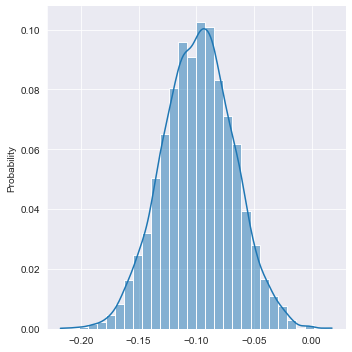

In [7]:
sns.displot(x = beta[:, 0], kind = "hist", stat = "probability", weights = w, kde = True, bins = 30)

Text(0.5, 0, 'lambda')

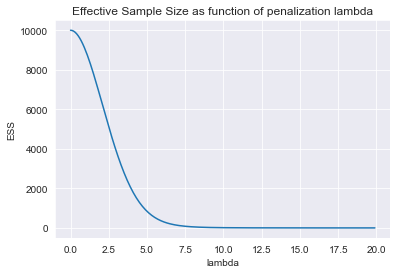

In [8]:
m = 10000
lamb = [k/10 for k in range(200)] 
ess = []
beta = mv_gaussian(m, p, X, Y, sig2)
for k in range(len(lamb)): 
    w, essk = impsamp(m, beta, X, Y, lamb[k], sig2)
    ess.append(essk)
plt.plot(lamb, ess)
plt.title("Effective Sample Size as function of penalization lambda")
plt.ylabel("ESS")
plt.xlabel("lambda")

# Importance sampling, variance inconnue (prior inverse gamma)

In [9]:
def mv_gaussiansig2(m, p, X, Y, sig2, Cmean, C):
    beta = np.empty(shape = (m, p))
    mean = scipy.linalg.solve_triangular(C.T, Cmean, lower = False)
    for i in range(m):
        z = np.random.randn(p)
        Cvar = scipy.linalg.solve_triangular(C.T, z, lower = False)
        beta[i, :] = (mean + np.sqrt(sig2[i])*Cvar)
    return beta

def impsampsig2(m, beta, sig2, X, Y, lamb):
    lw = np.empty(m)
    for i in range(m):
        lw[i] = -  lamb/np.sqrt(sig2[i]) * np.linalg.norm(beta[i, :], ord = 1)
    w = np.exp(lw-np.max(lw))
    w /= sum(w)
    ess = sum(w)**2/sum(w**2)
    return w, ess

In [10]:
ksig2 = 1
thetasig2 = 1
lamb = 1
m = 10000
C = np.linalg.cholesky(X.dot(X.T))
Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
Yz = Y.T.dot(Y)-Cmean.T.dot(Cmean)
sig2 = invgamma.rvs(a = ksig2+0.5*n, scale = thetasig2+0.5*Yz, size = m)
beta = mv_gaussiansig2(m, p, X, Y, sig2, Cmean, C)
w, ess = impsampsig2(m, beta, sig2, X, Y, lamb) 
ess

8779.25570730486

(-1.0, 1.0)

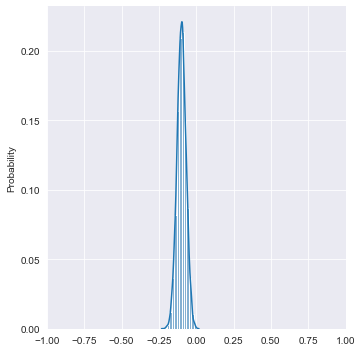

In [11]:
sns.set_style('darkgrid')
sns.displot(x = beta[:, 0], kind = "hist", stat = "probability", weights = w, kde = True, bins = 15)
plt.xlim(-1, 1)

Text(0.5, 0, 'lambda')

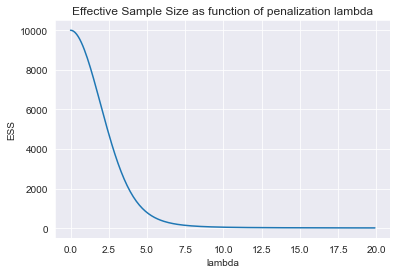

In [12]:
m = 10000
ksig2 = 1
thetasig2 = 1
lamb = [j/10 for j in range(200)] 
ess = []
C = np.linalg.cholesky(X.dot(X.T))
Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
Yz = Y.T.dot(Y)-Cmean.T.dot(Cmean)
sig2 = invgamma.rvs(a = ksig2+0.5*n, scale = thetasig2+0.5*Yz, size = m)
beta = mv_gaussiansig2(m, p, X, Y, sig2, Cmean, C)
for k in range(len(lamb)): 
    w, essk = impsampsig2(m, beta, sig2, X, Y, lamb[k])
    ess.append(essk)
plt.plot(lamb, ess)
plt.title("Effective Sample Size as function of penalization lambda")
plt.ylabel("ESS")
plt.xlabel("lambda")

# Gibbs sampler, variance connue

In [13]:
C = np.linalg.cholesky(X.dot(X.T))
Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
mean = scipy.linalg.solve_triangular(C.T, Cmean, lower = False)
sig2 = 1/n * np.sum((Y-X.T.dot(mean))**2)

In [14]:
def update_beta(X, Y, p, tau2inv, sig2):
    D_tauinv = np.diag(tau2inv)
    L = np.linalg.cholesky(X.dot(X.T)+D_tauinv)
    Lc = scipy.linalg.solve_triangular(L, X.dot(Y), lower = True)
    mean = scipy.linalg.solve_triangular(L.T, Lc, lower = False)
    z = np.random.randn(p)
    Lvar = scipy.linalg.solve_triangular(L.T, z, lower = False)
    return mean + np.sqrt (sig2)*Lvar

def update_tau2inv(X, Y, p, beta, sig2, lamb):
    mu = [np.sqrt(lamb**2 * sig2 / beta[i]**2) for i in range(p)]
    return [invgauss.rvs(mu[i]/lamb**2, scale = lamb**2, size = 1) for i in range(p)] #attention paramétrisation

def update_sig2(X, Y, p, beta, tau2inv, ksig2, thetasig2):
    a = 0.5*n+0.5*p+ksig2
    beta_tau = sum([beta[i]**2 * tau2inv[i] for i in range(p)])
    eps = np.linalg.norm(Y - X.T.dot(np.array(beta)), ord = 2)**2
    scale = thetasig2+0.5*(beta_tau + eps)
    return invgamma.rvs(a = a, scale = scale, size = 1)

def essmcmc(beta):
    nr,nc = beta.shape
    essmcmc = []
    for k in range(nc):
        betark = ro.r.matrix(beta[:, k], nrow=nr, ncol=1)
        ressk = reffectivesize(betark)
        essmcmc.append(ressk[0])
    return(essmcmc)

In [15]:
N = 1000
lamb = 1
tau2inv = np.empty((N, p))
beta = np.empty((N, p))
tau2 =  expon.rvs(scale = 2 / lamb**2, size = p)
tau2inv[0, :] = 1/tau2
for i in range(1, N):
    beta[i, :] = update_beta(X, Y, p, tau2inv[i-1, :], sig2)
    tau2inv[i, :] = update_tau2inv(X, Y, p, beta[i, :], sig2, lamb)

essmcmc(beta[100:, ])

[900.0000000000007,
 900.0000000000002,
 900.0000000000001,
 900.0,
 900.0000000000007,
 900.0000000000003,
 900.0000000000008,
 899.9999999999998,
 745.5044493345526,
 900.0000000000006,
 899.9999999999991,
 797.314638051959,
 899.9999999999998]

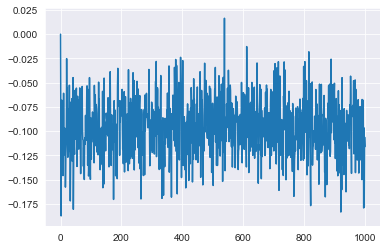

In [16]:
plt.plot(beta[:, 0])

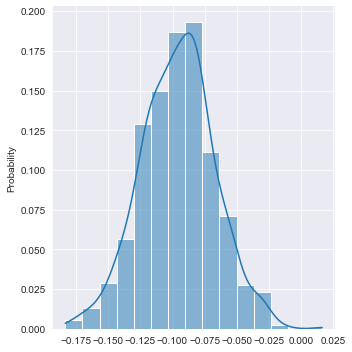

In [17]:
sns.displot(beta[100:,0], stat = "probability", bins = 15, kde = True)

C:\Users\rouau\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:652: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


<AxesSubplot:>

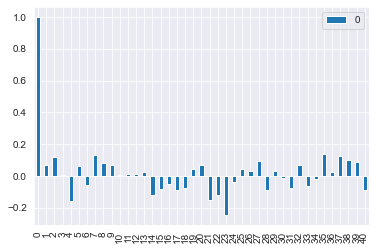

In [18]:
pd.DataFrame(acf(beta[100:200, 0], fft = True)).plot(kind = "bar")

Text(0.5, 0, 'lambda')

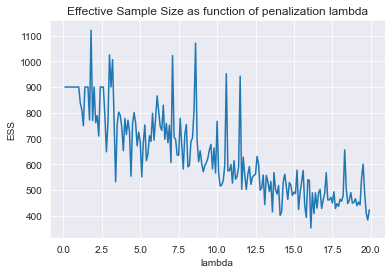

In [19]:
N = 1000
lamb = [k/10 for k in range(1, 200)] 
ess = []
for k in range(len(lamb)):
    tau2inv = np.empty((N, p))
    beta = np.empty((N, p))
    tau2 =  expon.rvs(scale = 2 / lamb[k]**2, size = p)
    tau2inv[0, :] = 1/tau2
    for i in range(1, N):
        beta[i, :] = update_beta(X, Y, p, tau2inv[i-1, :], sig2)
        tau2inv[i, :] = update_tau2inv(X, Y, p, beta[i, :], sig2, lamb[k])
    ess.append(essmcmc(beta[100:, ])[0])

plt.plot(lamb, ess)
plt.title("Effective Sample Size as function of penalization lambda")
plt.ylabel("ESS")
plt.xlabel("lambda")

# Gibbs sampler, variance inconnue

In [20]:
N = 1000
ksig2 = 1
thetasig2 = 10
lamb = 1
sig2 = np.empty(N)
tau2inv = np.empty((N, p))
beta = np.empty((N, p))
sig2[0] = invgamma.rvs(a = ksig2, scale = thetasig2)
tau2 = expon.rvs(scale = 2/lamb**2, size = p)
tau2inv[0, :] = 1/tau2

for i in range(1, N):
    beta[i, :] = update_beta(X, Y, p, tau2inv[i-1, :], sig2[i-1])
    tau2inv[i, :] = update_tau2inv(X, Y, p, beta[i, :], sig2[i-1], lamb)
    sig2[i] = update_sig2(X, Y, p, beta[i, :], tau2inv[i, :], ksig2, thetasig2)
    
essmcmc(beta[100:, ])

[900.0000000000005,
 900.0000000000003,
 1079.3852684058531,
 899.9999999999993,
 899.9999999999999,
 899.9999999999993,
 900.0000000000003,
 900.0000000000003,
 899.9999999999986,
 964.4630034497347,
 900.0000000000001,
 899.9999999999999,
 899.9999999999998]

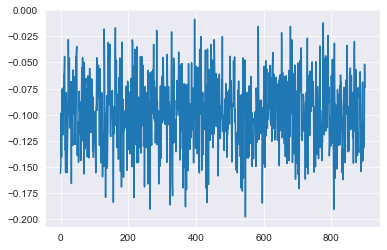

In [21]:
plt.plot(beta[100:, 0]) #rpy2

(-0.25, 0.25)

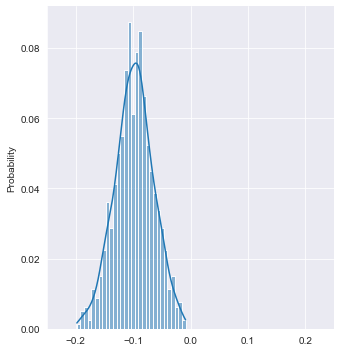

In [22]:
sns.displot(beta[200:,0], stat = "probability", kde = True, bins = 30)
plt.xlim(-0.25, 0.25)

C:\Users\rouau\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:652: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


<AxesSubplot:>

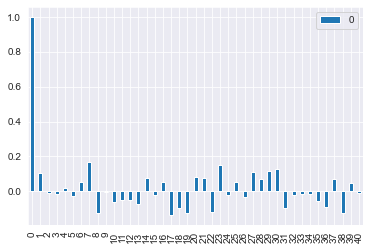

In [23]:
pd.DataFrame(acf(beta[10:100, 0], fft = True)).plot(kind = "bar")

Text(0.5, 0, 'lambda')

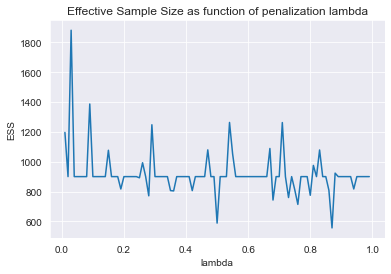

In [24]:
N = 1000
lamb = [k/100 for k in range(1, 100)]
ksig2 = 1
thetasig2 = 1
ess = []
for k in range(len(lamb)):
    sig2 = np.empty(N)
    tau2inv = np.empty((N, p))
    beta = np.empty((N, p))
    sig2[0] = invgamma.rvs(a = ksig2, scale = thetasig2)
    tau2 = expon.rvs(scale = 2/lamb[k]**2, size = p)
    tau2inv[0, :] = 1/tau2
    for i in range(1, N):
        beta[i, :] = update_beta(X, Y, p, tau2inv[i-1, :], sig2[i-1])
        tau2inv[i, :] = update_tau2inv(X, Y, p, beta[i, :], sig2[i-1], lamb[k])
        sig2[i] = update_sig2(X, Y, p, beta[i, :], tau2inv[i, :], ksig2, thetasig2)
    ess.append(essmcmc(beta[100:, ])[0])

plt.plot(lamb, ess)
plt.title("Effective Sample Size as function of penalization lambda")
plt.ylabel("ESS")
plt.xlabel("lambda")

# Comparaison des deux méthodes

# Variance connue

In [25]:
C = np.linalg.cholesky(X.dot(X.T))
Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
mean = scipy.linalg.solve_triangular(C.T, Cmean, lower = False)
sig2 = 1/n * np.sum((Y-X.T.dot(mean))**2)

In [26]:
lamb = 1
m = 10000
size = 1000
timp0 = time.time()
beta0 = mv_gaussian(m, p, X, Y, sig2)
w, ess = impsamp(m, beta0, X, Y, lamb, sig2)
timp = time.time()-timp0
sampl = beta0[np.random.choice(len(beta0), p = w, size = size, replace = True)]

N = m+100
tmcmc0 = time.time()
tau2inv = np.empty((N, p))
beta = np.empty((N, p))
tau2 = expon.rvs(scale = 2/lamb**2, size = p)
tau2inv[0, :] = 1/tau2

for i in range(1, N):
    beta[i, :] = update_beta(X, Y, p, tau2inv[i-1, :], sig2)
    tau2inv[i, :] = update_tau2inv(X, Y, p, beta[i, :], sig2, lamb)
tmcmc = time.time()-tmcmc0
sampl2 = beta[-size:, ]

imp = [np.average(beta0[:, i], weights = w) for i in range(p)]
vimp = [N*np.average((beta0[:, i]-imp[i])**2, weights = w**2)/ess for i in range(p)]
g = [sum(acf(beta[50:, i], fft = True)) for i in range(p)]
v = [np.var(beta[50:, i]) for i in range(p)]
vmcmc = [v[i]*(1+2*g[i]) for i in range(p)]
iris = [vmcmc[i]/vimp[i] * timp / tmcmc for i in range(p)]

<ipython-input-27-264049351a69>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-27-264049351a69>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
<ipython-input-27-264049351a69>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


KstestResult(statistic=0.041, pvalue=0.37012017606173)

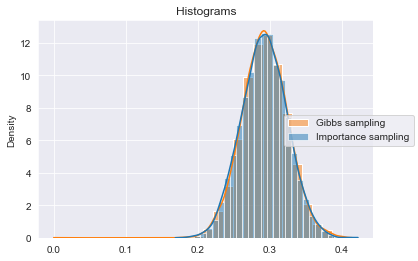

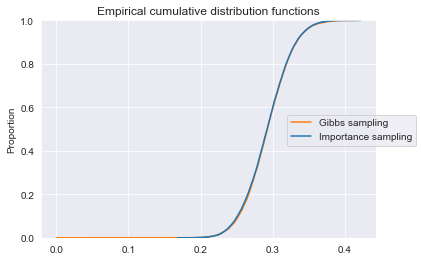

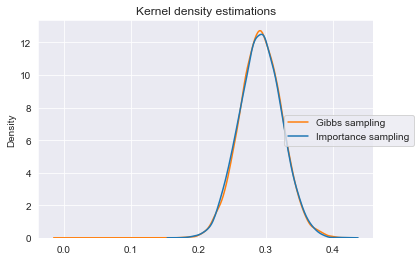

In [27]:
i = 5
fig, ax = plt.subplots()
h1 = sns.histplot(x = beta[:, i], stat = "density", kde = True, bins = 30, 
                  ax = ax, label = "Gibbs sampling", color = "tab:orange")
h2 = sns.histplot(x = beta0[:, i], stat = "density", kde = True, bins = 30, 
                  ax = ax, label = "Importance sampling", color = "tab:blue", weights = w)
ax.set_title("Histograms")
fig.legend(loc = "right")
fig.show()

fig2, ax2 = plt.subplots()
f1 = sns.ecdfplot(x = beta[:, i], ax = ax2, label = "Gibbs sampling", color = "tab:orange")
f2 = sns.ecdfplot(x = beta0[:, i], ax = ax2, label = "Importance sampling", color = "tab:blue", weights = w)
ax2.set_title("Empirical cumulative distribution functions")
fig2.legend(loc = "right")
fig2.show()

fig3, ax3= plt.subplots()
kd1 = sns.kdeplot(x = beta[:, i], ax = ax3, label = "Gibbs sampling", color = "tab:orange")
kd2 = sns.kdeplot(x = beta0[:, i], ax = ax3, label = "Importance sampling", color = "tab:blue", weights = w)
ax3.set_title("Kernel density estimations")
fig3.legend(loc = "right")
fig3.show()

scipy.stats.ks_2samp(sampl[:, i], sampl2[:, i])

In [28]:
timp, tmcmc

(0.3777127265930176, 10.348585367202759)

In [29]:
vimp, vmcmc

([0.0010280938156999177,
  0.0013165839582057564,
  0.001991731888233958,
  0.0006249774374862816,
  0.0026207779619543707,
  0.0011283870856018596,
  0.001590539369591816,
  0.0023108310556586432,
  0.004530164673651151,
  0.005220948136950711,
  0.0010364989583609675,
  0.0007769611025764289,
  0.001684184491830881],
 [0.0025538115337933416,
  0.003489370158318852,
  0.006297325785704544,
  0.0017939432036676167,
  0.007295226931629782,
  0.002891437238474854,
  0.004893488909177077,
  0.006089950656836411,
  0.011595349116967366,
  0.01446669536977574,
  0.0026762744660619605,
  0.002000874995039935,
  0.004421002804716617])

Text(0.5, 1.0, 'IRIS variance connue')

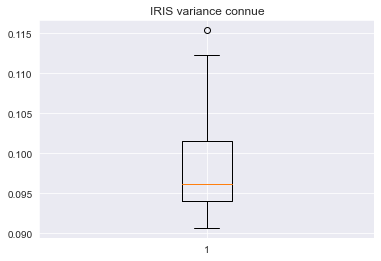

In [30]:
plt.boxplot(iris)
plt.title("IRIS variance connue")

In [31]:
ess

8952.142629767535

In [32]:
essmcmc(beta[100:, :])

[9601.925602353132,
 9574.039918265635,
 9311.10717041046,
 9136.21929935782,
 9067.981481885934,
 10000.000000000044,
 10000.000000000024,
 9506.742515173471,
 9519.296306341837,
 9190.435570815385,
 9999.999999999976,
 9824.15414181098,
 9999.999999999985]

# Variance inconnue

In [114]:
ksig2 = 1
thetasig2 = 1
lamb = 2
m = 10000
size = 1000
timp0 = time.time()
C = np.linalg.cholesky(X.dot(X.T))
Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
Yz = Y.T.dot(Y)-Cmean.T.dot(Cmean)
sig2 = invgamma.rvs(a = ksig2+0.5*n, scale = thetasig2+0.5*Yz, size = m)
beta0 = mv_gaussiansig2(m, p, X, Y, sig2, Cmean, C)
w, ess = impsampsig2(m, beta0, sig2, X, Y, lamb)
timp = time.time()-timp0
sampl = beta0[np.random.choice(len(beta0), p = w, size = size, replace = True)]


N = m+100
tmcmc0 = time.time()
sig2 = np.empty(N)
tau2inv = np.empty((N, p))
beta = np.empty((N, p))
sig2[0] = invgamma.rvs(a = ksig2, scale = thetasig2)
tau2 = expon.rvs(scale = 2/lamb**2, size = p)
tau2inv[0, :] = 1/tau2

for i in range(1, N):
    beta[i, :] = update_beta(X, Y, p, tau2inv[i-1, :], sig2[i-1])
    tau2inv[i, :] = update_tau2inv(X, Y, p, beta[i, :], sig2[i-1], lamb)
    sig2[i] = update_sig2(X, Y, p, beta[i, :], tau2inv[i, :], ksig2, thetasig2)
    tmcmc = time.time()-tmcmc0
sampl2 = beta[-size:, ]

imp = [np.average(beta0[:, i], weights = w) for i in range(p)]
vimp = [N*np.average((beta0[:, i]-imp[i])**2, weights = w**2)/ess for i in range(p)]
g = [sum(acf(beta[50:, i], fft = True)) for i in range(p)]
v = [np.var(beta[50:, i]) for i in range(p)]
vmcmc = [v[i]*(1+2*g[i]) for i in range(p)]
iris = [vmcmc[i]/vimp[i] * timp / tmcmc for i in range(p)]

C:\Users\rouau\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:652: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


<ipython-input-115-1213db7c8391>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-115-1213db7c8391>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
<ipython-input-115-1213db7c8391>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


KstestResult(statistic=0.049, pvalue=0.18116454248303263)

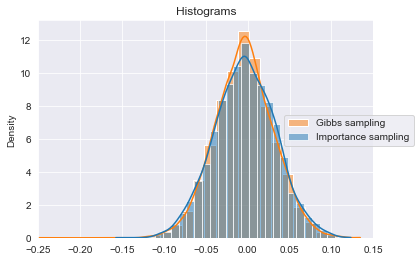

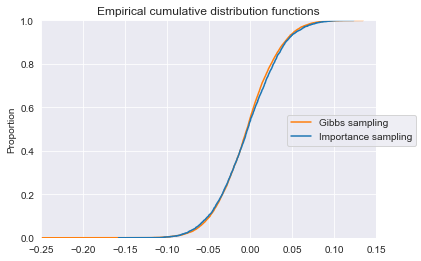

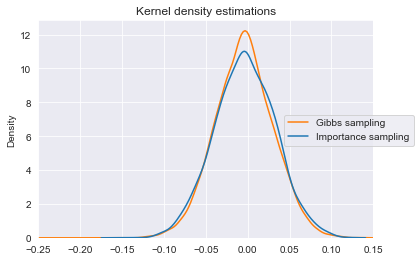

In [115]:
i = 0
fig, ax = plt.subplots()
h1 = sns.histplot(x = beta[:, i], stat = "density", bins = 30, kde = True, 
                  ax = ax, label = "Gibbs sampling", color = "tab:orange")
h2 = sns.histplot(x = beta0[:, i], stat = "density", bins = 30,  kde = True, 
                  ax = ax, label = "Importance sampling", color = "tab:blue", weights =w)
ax.set_title("Histograms")
fig.legend(loc = "right")
plt.xlim(-0.25, 0.15)
fig.show()

fig2, ax2 = plt.subplots()
f1 = sns.ecdfplot(x = beta[:, i], ax = ax2, label = "Gibbs sampling", color = "tab:orange")
f2 = sns.ecdfplot(x = beta0[:, i], ax = ax2, label = "Importance sampling", color = "tab:blue", weights = w)
ax2.set_title("Empirical cumulative distribution functions")
fig2.legend(loc = "right")
plt.xlim(-0.25, 0.15)
fig2.show()

fig3, ax3= plt.subplots()
kd1 = sns.kdeplot(x = beta[:, i], ax = ax3, label = "Gibbs sampling", color = "tab:orange")
kd2 = sns.kdeplot(x = beta0[:, i], ax = ax3, label = "Importance sampling", color = "tab:blue", weights = w)
ax3.set_title("Kernel density estimations")
fig3.legend(loc = "right")
plt.xlim(-0.25, 0.15)
fig3.show()

scipy.stats.ks_2samp(sampl[:, i], sampl2[:, i])

In [35]:
timp, tmcmc

(0.3866558074951172, 11.887663841247559)

In [36]:
vimp, vmcmc

([0.0016418262196684493,
  0.0021196990941452693,
  0.002907205991951755,
  0.0009050671412395773,
  0.004214287843031242,
  0.0017147110718485142,
  0.002256942310845059,
  0.003576462654908917,
  0.008899938617941429,
  0.009497820881026096,
  0.0016042579598226888,
  0.0011864163894342514,
  0.0024880149707164844],
 [0.0028677928932931552,
  0.003659157786287226,
  0.005634798526062526,
  0.0017574102754958439,
  0.007240374823010591,
  0.0029546362481988066,
  0.0042818342543055376,
  0.006173513372362122,
  0.012667881309616685,
  0.014119669155287578,
  0.0027833937763438485,
  0.002189528300869405,
  0.004498568539659163])

Text(0.5, 1.0, 'IRIS variance inconnue')

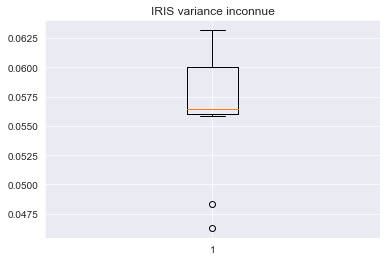

In [37]:
plt.boxplot(iris)
plt.title("IRIS variance inconnue")

In [38]:
ess

5977.599499652961

In [39]:
essmcmc(beta[100:, :])

[9384.760191496141,
 8980.583793598782,
 8726.642427625009,
 9433.295783989997,
 8510.373269492085,
 9317.801208749805,
 9444.828948398981,
 8328.597246899266,
 8216.52186590022,
 8139.480676004018,
 9440.983263604618,
 9098.71404497229,
 9591.571704873195]

# Test sur des données corrélées

In [40]:
def gencorr(n, p, alpha, k, delta, alpha0):
    alpha0 = alpha0/np.sum(alpha0**2)
    X = np.empty((p, n))
    V = np.random.randn(p, n)
    for i in range(k):
        X[i, :] = V[i, :]
    for i in range(k, p):
        X[i, :] = np.sqrt(1-alpha**2)*V[i, :]
        for j in range(k):
            X[i, :]+= alpha*alpha0[j]*X[j, :]
    eps = np.random.randn(n)
    Y = X.T.dot(delta)+eps
    X= normalize(X.T)
    Y = (Y-np.mean(Y))/np.std(Y)
    return X, Y

def gensc():
    Z = np.random.randn(16, 180)
    X = np.empty((15, 180))
    I = [1, 3, 5, 8, 9, 10, 12, 13, 14, 15]
    for i in I:
        X[i-1,:] = Z[i-1, :]+2*Z[-1, :]
    X[1, :] = X[0, :] + 0.15*Z[1, :]
    X[3, :] = X[2, :] + 0.15*Z[3, :]
    X[5, :] = X[4, :] + 0.15*Z[5, :]
    X[6, :] = X[7, :] + X[8, :] - X[9, :] + Z[6, :]
    X[10, :] = X[13, :] + X[14, :] - X[11, :] - X[12, :] + Z[10, :]
    delta = np.array([1.5, 0, 1.5, 0, 1.5, 0, 1.5, -1.5, 0, 0, 1.5, 1.5, 1.5, 0, 0])
    u = np.random.randn(180)
    Y = X.T.dot(delta)+2.5*u
    X= normalize(X.T)
    Y = (Y-np.mean(Y))/np.std(Y)
    return X, Y
    

# Variance connue

# Histogrammes

In [41]:
alpha = 0.6
p = 15
n = 100
alpha0 = np.array([1])
k = len(alpha0)
delta = np.array([0 if c%4 == 0 else np.random.randn() for c in range(p)])
X, Y = gencorr(n, p, alpha, k, delta, alpha0)

In [42]:
C = np.linalg.cholesky(X.dot(X.T))
Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
mean = scipy.linalg.solve_triangular(C.T, Cmean, lower = False)
sig2 = 1/n * np.sum((Y-X.T.dot(mean))**2)

In [43]:
lamb = 1
m = 10000
size = 1000
timp0 = time.time()
beta0 = mv_gaussian(m, p, X, Y, sig2)
w, ess = impsamp(m, beta0, X, Y, lamb, sig2)
timp = time.time() - timp0
sampl = beta0[np.random.choice(len(beta0), p = w, size = size, replace = True)]

N = m
tmcmc0 = time.time()
tau2inv = np.empty((N, p))
beta = np.empty((N, p))
tau2 = expon.rvs(scale = 2/lamb**2, size = p)
tau2inv[0, :] = 1/tau2

for i in range(1, N):
    beta[i, :] = update_beta(X, Y, p, tau2inv[i-1, :], sig2)
    tau2inv[i, :] = update_tau2inv(X, Y, p, beta[i, :], sig2, lamb)
tmcmc = time.time() - tmcmc0
sampl2 = beta[-size:, ]

imp = [np.average(beta0[:, i], weights = w) for i in range(p)]
vimp = [N*np.average((beta0[:, i]-imp[i])**2, weights = w**2)/ess for i in range(p)]
g = [sum(acf(beta[50:, i], fft = True)) for i in range(p)]
v = [np.var(beta[50:, i]) for i in range(p)]
vmcmc = [v[i]*(1+2*g[i]) for i in range(p)]
iris = [vmcmc[i]/vimp[i] * timp / tmcmc for i in range(p)]

C:\Users\rouau\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:652: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


<ipython-input-44-4c8f613de8c8>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-44-4c8f613de8c8>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
<ipython-input-44-4c8f613de8c8>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


KstestResult(statistic=0.036, pvalue=0.5362766985932181)

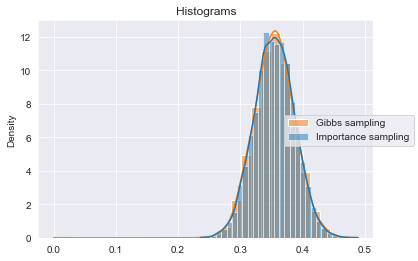

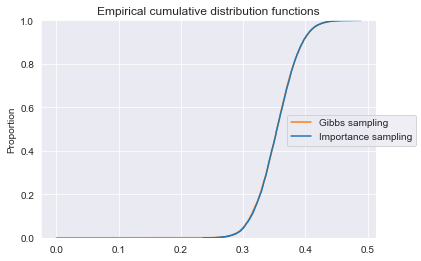

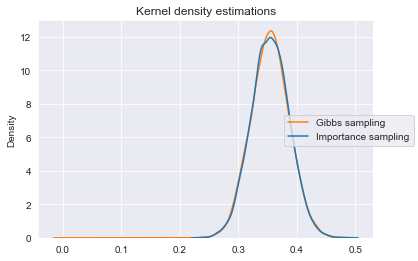

In [44]:
i = 5
fig, ax = plt.subplots()
h1 = sns.histplot(x = beta[:, i], stat = "density", kde = True, bins = 30, 
                  ax = ax, label = "Gibbs sampling", color = "tab:orange")
h2 = sns.histplot(x = beta0[:, i], stat = "density", kde = True, bins = 30, 
                  ax = ax, label = "Importance sampling", color = "tab:blue", weights = w)
ax.set_title("Histograms")
fig.legend(loc = "right")
fig.show()

fig2, ax2 = plt.subplots()
f1 = sns.ecdfplot(x = beta[:, i], ax = ax2, label = "Gibbs sampling", color = "tab:orange")
f2 = sns.ecdfplot(x = beta0[:, i], ax = ax2, label = "Importance sampling", color = "tab:blue", weights = w)
ax2.set_title("Empirical cumulative distribution functions")
fig2.legend(loc = "right")
fig2.show()

fig3, ax3= plt.subplots()
kd1 = sns.kdeplot(x = beta[:, i], ax = ax3, label = "Gibbs sampling", color = "tab:orange")
kd2 = sns.kdeplot(x = beta0[:, i], ax = ax3, label = "Importance sampling", color = "tab:blue", weights = w)
ax3.set_title("Kernel density estimations")
fig3.legend(loc = "right")
fig3.show()


scipy.stats.ks_2samp(sampl[:, i], sampl2[:, i])

In [45]:
timp, tmcmc

(0.3587064743041992, 8.921688079833984)

Text(0.5, 1.0, 'IRIS variance connue')

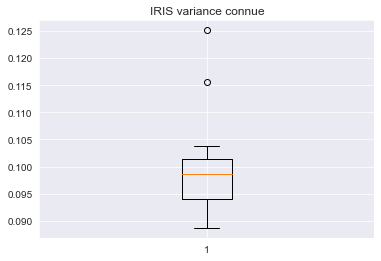

In [46]:
plt.boxplot(iris)
plt.title("IRIS variance connue")

# Effective sample size

In [47]:
alpha = [k/100 for k in range(1, 51)]+[k/200 for k in range(100, 199)]
alpha0 = np.array([1, 0.5, 0.2, 0.17, .001])
k0 = len(alpha0)
p = 15
n = 100
lamb = 1
m = 1000
N = m+100
ess = []
essgibbs = []
delta = np.array([0 if k%3 == 0 else np.random.randn() for k in range(p)])
for k in range(len(alpha)):

    X, Y = gencorr(n, p, alpha[k], k0, delta, alpha0)
    #sig2
    C = np.linalg.cholesky(X.dot(X.T))
    Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
    mean = scipy.linalg.solve_triangular(C.T, Cmean, lower = False)
    sig2 = 1/n * np.sum((Y-X.T.dot(mean))**2)
    #IS
    beta0 = mv_gaussian(m, p, X, Y, sig2)
    w, essk = impsamp(m, beta0, X, Y, lamb, sig2)
    ess.append(essk)
    #Gibbs
    tau2inv = np.empty((N, p))
    beta = np.empty((N, p))
    tau2 =  expon.rvs(scale = 2 / lamb**2, size = p)
    tau2inv[0, :] = 1/tau2
    for i in range(1, N):
        beta[i, :] = update_beta(X, Y, p, tau2inv[i-1, :], sig2)
        tau2inv[i, :] = update_tau2inv(X, Y, p, beta[i, :], sig2, lamb)
    essgibbs.append(essmcmc(beta[100:, ])[0])

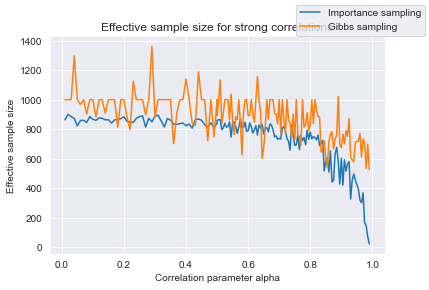

In [48]:
fig, ax = plt.subplots()
plt.plot(alpha, ess, color = "tab:blue", label = "Importance sampling")
plt.plot(alpha, essgibbs, color = "tab:orange", label = "Gibbs sampling")
plt.ylabel("Effective sample size")
plt.xlabel("Correlation parameter alpha")
ax.set_title("Effective sample size for strong correlations")
fig.legend(loc = "upper right")
plt.show()

# En générant la forte corrélation comme George et McCulloch

C:\Users\rouau\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:652: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
<ipython-input-49-36e6fde419d1>:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-49-36e6fde419d1>:51: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
<ipython-input-49-36e6fde419d1>:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


KstestResult(statistic=0.058, pvalue=0.06917625399020766)

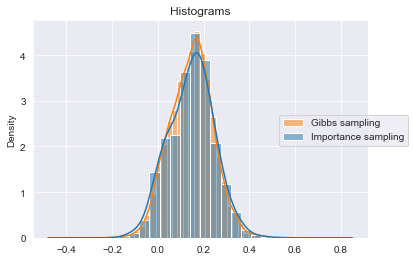

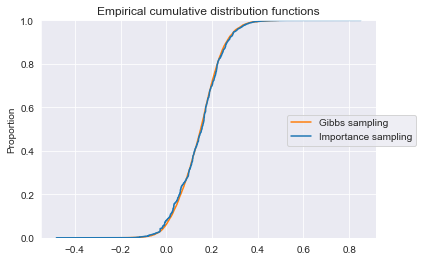

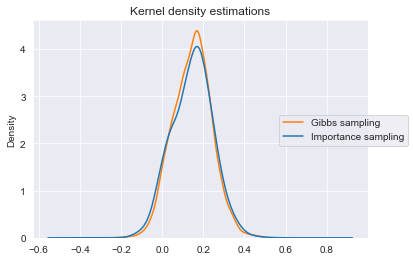

In [49]:
p = 15
n = 180
X, Y = gensc()
C = np.linalg.cholesky(X.dot(X.T))
Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
mean = scipy.linalg.solve_triangular(C.T, Cmean, lower = False)
sig2 = 1/n * np.sum((Y-X.T.dot(mean))**2)
lamb = 1
m = 10000
size = 1000
timp0 = time.time()
beta0 = mv_gaussian(m, p, X, Y, sig2)
w, ess = impsamp(m, beta0, X, Y, lamb, sig2)
timp = time.time() - timp0
sampl = beta0[np.random.choice(len(beta0), p = w, size = size, replace = True)]

N = m
tmcmc0 = time.time()
tau2inv = np.empty((N, p))
beta = np.empty((N, p))
tau2 = expon.rvs(scale = 2/lamb**2, size = p)
tau2inv[0, :] = 1/tau2

for i in range(1, N):
    beta[i, :] = update_beta(X, Y, p, tau2inv[i-1, :], sig2)
    tau2inv[i, :] = update_tau2inv(X, Y, p, beta[i, :], sig2, lamb)
tmcmc = time.time() - tmcmc0
sampl2 = beta[-size:, ]

imp = [np.average(beta0[:, i], weights = w) for i in range(p)]
vimp = [N*np.average((beta0[:, i]-imp[i])**2, weights = w**2)/ess for i in range(p)]
g = [sum(acf(beta[50:, i], fft = True)) for i in range(p)]
v = [np.var(beta[50:, i]) for i in range(p)]
vmcmc = [v[i]*(1+2*g[i]) for i in range(p)]
iris = [vmcmc[i]/vimp[i] * timp / tmcmc for i in range(p)]
i = 5
fig, ax = plt.subplots()
h1 = sns.histplot(x = beta[:, i], stat = "density", kde = True, bins = 30, 
                  ax = ax, label = "Gibbs sampling", color = "tab:orange")
h2 = sns.histplot(x = beta0[:, i], stat = "density", kde = True, bins = 30, 
                  ax = ax, label = "Importance sampling", color = "tab:blue", weights = w)
ax.set_title("Histograms")
fig.legend(loc = "right")
fig.show()

fig2, ax2 = plt.subplots()
f1 = sns.ecdfplot(x = beta[:, i], ax = ax2, label = "Gibbs sampling", color = "tab:orange")
f2 = sns.ecdfplot(x = beta0[:, i], ax = ax2, label = "Importance sampling", color = "tab:blue", weights = w)
ax2.set_title("Empirical cumulative distribution functions")
fig2.legend(loc = "right")
fig2.show()

fig3, ax3= plt.subplots()
kd1 = sns.kdeplot(x = beta[:, i], ax = ax3, label = "Gibbs sampling", color = "tab:orange")
kd2 = sns.kdeplot(x = beta0[:, i], ax = ax3, label = "Importance sampling", color = "tab:blue", weights = w)
ax3.set_title("Kernel density estimations")
fig3.legend(loc = "right")
fig3.show()


scipy.stats.ks_2samp(sampl[:, i], sampl2[:, i])

In [50]:
ess

372.2954390512059

In [51]:
essmcmc(beta[100:, :])

[5946.144571522161,
 6104.067586901293,
 5428.5267865092865,
 5495.21041752149,
 5673.24246213744,
 5588.841291337577,
 8468.407177046285,
 8915.664472442662,
 7979.977553648216,
 8545.4521592886,
 8176.779892727432,
 8596.649901362618,
 8334.997370406216,
 7635.532845315541,
 8482.321294314197]

# Variance inconnue

# Histogrammes

In [52]:
alpha = 0.7
p = 15
n = 100
alpha0 = np.array([1])
k = len(alpha0)
delta = np.array([0 if c%3 == 0 else np.random.randn() for c in range(p)])
X, Y = gencorr(n, p, alpha, k, delta, alpha0)

In [53]:
ksig2 = 1
thetasig2 = 1
lamb = 1
m = 10000
size = 1000
timp0 = time.time()
C = np.linalg.cholesky(X.dot(X.T))
Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
Yz = Y.T.dot(Y)-Cmean.T.dot(Cmean)
sig2 = invgamma.rvs(a = ksig2+0.5*n, scale = thetasig2+0.5*Yz, size = m)
beta0 = mv_gaussiansig2(m, p, X, Y, sig2, Cmean, C)
w, ess = impsampsig2(m, beta0, sig2, X, Y, lamb)
timp = time.time()-timp0
sampl = beta0[np.random.choice(len(beta0), p = w, size = size, replace = True)]


N = m+100
tmcmc0 = time.time()
sig2 = np.empty(N)
tau2inv = np.empty((N, p))
beta = np.empty((N, p))
sig2[0] = invgamma.rvs(a = ksig2, scale = thetasig2)
tau2 = expon.rvs(scale = 2/lamb**2, size = p)
tau2inv[0, :] = 1/tau2

for i in range(1, N):
    beta[i, :] = update_beta(X, Y, p, tau2inv[i-1, :], sig2[i-1])
    tau2inv[i, :] = update_tau2inv(X, Y, p, beta[i, :], sig2[i-1], lamb)
    sig2[i] = update_sig2(X, Y, p, beta[i, :], tau2inv[i, :], ksig2, thetasig2)
    tmcmc = time.time()-tmcmc0
sampl2 = beta[-size:, ]

imp = [np.average(beta0[:, i], weights = w) for i in range(p)]
vimp = [N*np.average((beta0[:, i]-imp[i])**2, weights = w**2)/ess for i in range(p)]
g = [sum(acf(beta[50:, i], fft = True)) for i in range(p)]
v = [np.var(beta[50:, i]) for i in range(p)]
vmcmc = [v[i]*(1+2*g[i]) for i in range(p)]
iris = [vmcmc[i]/vimp[i] * timp / tmcmc for i in range(p)]

C:\Users\rouau\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:652: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


<ipython-input-54-b363567794cf>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-54-b363567794cf>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
<ipython-input-54-b363567794cf>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


KstestResult(statistic=0.037, pvalue=0.5005673707894058)

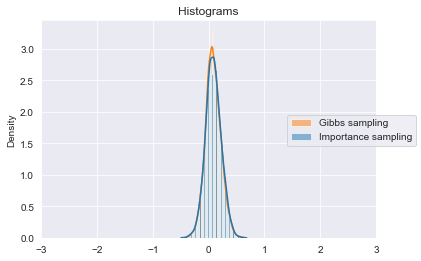

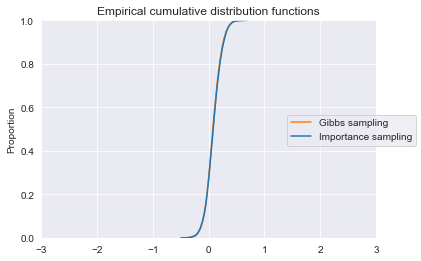

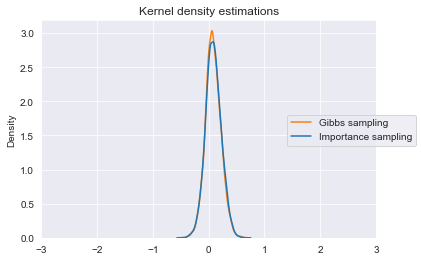

In [54]:
i = 0
fig, ax = plt.subplots()
h1 = sns.histplot(x = beta[100:, i], stat = "density", bins = 50, kde = True, 
                  ax = ax, label = "Gibbs sampling", color = "tab:orange")
h2 = sns.histplot(x = beta0[:, i], stat = "density", bins = 50,  kde = True, 
                  ax = ax, label = "Importance sampling", color = "tab:blue", weights =w)
ax.set_title("Histograms")
fig.legend(loc = "right")
plt.xlim(-3, 3)
fig.show()

fig2, ax2 = plt.subplots()
f1 = sns.ecdfplot(x = beta[100:, i], ax = ax2, label = "Gibbs sampling", color = "tab:orange")
f2 = sns.ecdfplot(x = beta0[:, i], ax = ax2, label = "Importance sampling", color = "tab:blue", weights = w)
ax2.set_title("Empirical cumulative distribution functions")
fig2.legend(loc = "right")
plt.xlim(-3, 3)
fig2.show()

fig3, ax3= plt.subplots()
kd1 = sns.kdeplot(x = beta[100:, i], ax = ax3, label = "Gibbs sampling", color = "tab:orange")
kd2 = sns.kdeplot(x = beta0[:, i], ax = ax3, label = "Importance sampling", color = "tab:blue", weights = w)
ax3.set_title("Kernel density estimations")
fig3.legend(loc = "right")
plt.xlim(-3, 3)
fig3.show()

scipy.stats.ks_2samp(sampl[:, i], sampl2[:, i])

In [55]:
timp, tmcmc

(0.43879270553588867, 10.601495027542114)

Text(0.5, 1.0, 'IRIS variance inconnue')

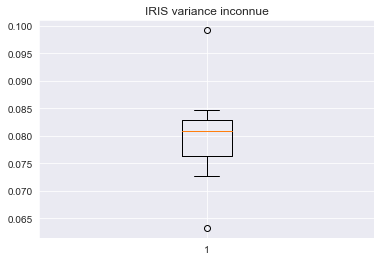

In [56]:
plt.boxplot(iris)
plt.title("IRIS variance inconnue")

# Effective sample size

In [57]:
alpha = [k/100 for k in range(1, 51)]+[k/200 for k in range(100, 199)]
alpha0 = np.array([1, 0.7, 0.4, 0.17, 0.005])
k0 = len(alpha0)
p = 15
n = 100
lamb = 1
ksig2 = 1
thetasig2 = 1
m = 1000
N = m+100
ess = []
essgibbs = []
delta = np.array([0 if k%3 == 0 else np.random.randn() for k in range(p)])
for k in range(len(alpha)):

    X, Y = gencorr(n, p, alpha[k], k0, delta, alpha0)
    #IS
    C = np.linalg.cholesky(X.dot(X.T))
    Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
    Yz = Y.T.dot(Y)-Cmean.T.dot(Cmean)
    sig2 = invgamma.rvs(a = ksig2+0.5*n, scale = thetasig2+0.5*Yz, size = m)
    beta0 = mv_gaussiansig2(m, p, X, Y, sig2, Cmean, C)
    w, essk = impsampsig2(m, beta0, sig2, X, Y, lamb) 
    ess.append(essk)
    #Gibbs
    sig2 = np.empty(N)
    tau2inv = np.empty((N, p))
    beta = np.empty((N, p))
    sig2[0] = invgamma.rvs(a = ksig2, scale = thetasig2)
    tau2 = expon.rvs(scale = 2/lamb**2, size = p)
    tau2inv[0, :] = 1/tau2

    for i in range(1, N):
        beta[i, :] = update_beta(X, Y, p, tau2inv[i-1, :], sig2[i-1])
        tau2inv[i, :] = update_tau2inv(X, Y, p, beta[i, :], sig2[i-1], lamb)
        sig2[i] = update_sig2(X, Y, p, beta[i, :], tau2inv[i, :], ksig2, thetasig2)
    essgibbs.append(essmcmc(beta[100:, ])[0])

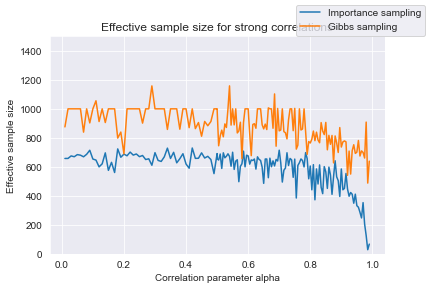

In [58]:
fig, ax = plt.subplots()
plt.plot(alpha, ess, color = "tab:blue", label = "Importance sampling")
plt.plot(alpha, essgibbs, color = "tab:orange", label = "Gibbs sampling")
plt.ylabel("Effective sample size")
plt.xlabel("Correlation parameter alpha")
ax.set_title("Effective sample size for strong correlations")
fig.legend(loc = "upper right")
plt.ylim(0, 1500)
plt.show()

# Bayesian Bridge

# Importance sampling

In [104]:
X, Y = load_boston(return_X_y=True)
n, p = X.shape
X= normalize(X)
Y = (Y-np.mean(Y))/np.std(Y)

In [60]:
def impsampbridge(m, beta, X, Y, tau, alpha):
    lw = np.empty(m)
    for i in range(m):
        zi = np.abs(beta[i, :]/tau)
        lw[i] = - np.sum(zi**alpha)
    w = np.exp(lw-np.max(lw))
    w /= sum(w)
    ess = sum(w)**2/sum(w**2)
    return w, ess

In [61]:
C = np.linalg.cholesky(X.dot(X.T))
Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
mean = scipy.linalg.solve_triangular(C.T, Cmean, lower = False)
sig2 = 1/n * np.sum((Y-X.T.dot(mean))**2)

In [62]:
nu = 1
alpha = 0.8
tau = nu**(-1/alpha)
m = 10000
beta = mv_gaussian(m, p, X, Y, sig2)
w, ess = impsampbridge(m, beta, X, Y, tau, alpha)
sampl = beta[np.random.choice(len(beta), p = w, size = 1000, replace = True)]
ess

9639.645354419004

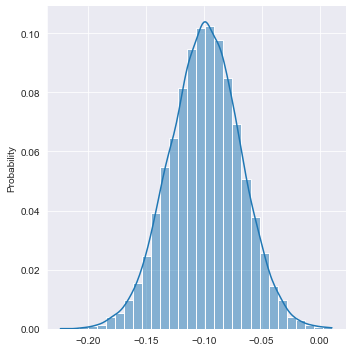

In [63]:
sns.displot(x = beta[:, 0], kind = "hist", stat = "probability", weights = w, kde = True, bins = 30)

Text(0.5, 0, 'nu')

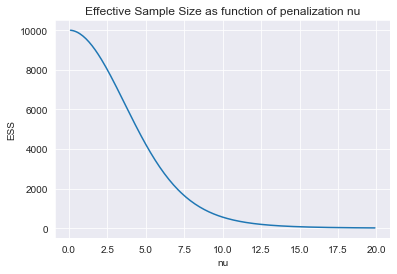

In [64]:
m = 10000
nu = [k/10 for k in range(1, 200)]
alpha = 0.8
tau = [nu[k]**(-1/alpha) for k in range(len(nu))] 
ess = []
beta = mv_gaussian(m, p, X, Y, sig2)
for k in range(len(tau)): 
    w, essk = impsampbridge(m, beta, X, Y, tau[k], alpha)
    ess.append(essk)
plt.plot(nu, ess)
plt.title("Effective Sample Size as function of penalization nu")
plt.ylabel("ESS")
plt.xlabel("nu")

Text(0.5, 0, 'alpha')

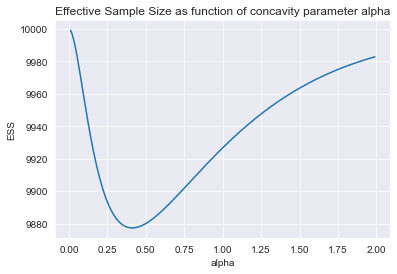

In [65]:
m = 10000
nu = 0.5
alpha = [k/100 for k in range(1, 200)]
tau = [nu**(-1/alpha[k]) for k in range(len(alpha))] 
ess = []
beta = mv_gaussian(m, p, X, Y, sig2)
for k in range(len(alpha)): 
    w, essk = impsampbridge(m, beta, X, Y, tau[k], alpha[k])
    ess.append(essk)
plt.plot(alpha, ess)
plt.title("Effective Sample Size as function of concavity parameter alpha")
plt.ylabel("ESS")
plt.xlabel("alpha")

# MCMC

In [66]:
def update_u(beta, W, tau, alpha, p):
    u = np.empty(p)
    for j in range(p):
        cj = 1-W[j]**(-1/alpha) * np.abs(beta[j]/tau)
        u[j] = np.random.random()*cj if cj>=0 else 0
    return(u)

def update_w(beta, u, tau, alpha, p):
    w = np.empty(p)
    for j in range(p):
        aj = (abs(beta[j]/tau)/(1-u[j]))**alpha
        zj = np.random.random()
        if zj <= alpha/(1+alpha*aj):
            wj = gamma.rvs(a = 2, scale = 1)
        else :
            wj = gamma.rvs(a = 1, scale = 1)
        w[j] = wj+aj
    return(w)
    
def update_beta_bridge(betap, Vinv, u, W, tau, alpha, p, sig2, mu):
    beta = np.empty(p)
    #truncated multivariate gaussian
    for j in range(p):
        j_ = np.array([k for k in range(p) if k != j])
        betaj_ = [betap[k] if k >j else beta[k] for k in j_]
        bj = W[j]**(1/alpha) * tau*(1-u[j])

        meanj = mu[j] - Vinv[j, j_].dot(betaj_-mu[j_])/Vinv[j, j]
        scalej = sig2/Vinv[j, j]
        clipbj = abs((bj-meanj)/scalej)
        beta[j] = truncnorm.rvs(a = -clipbj, b = clipbj ,loc = meanj, scale = np.sqrt(scalej), size = 1)
    return beta
    


In [67]:
N = 1000+100
nu = 1
alpha = 1
tau = nu**(-1/alpha)

C = np.linalg.cholesky(X.dot(X.T))
Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
mu = scipy.linalg.solve_triangular(C.T, Cmean, lower = False)
Vinv = X.dot(X.T)

u = np.empty((N, p))
W = np.empty((N, p))
beta = np.empty((N, p))


beta[0, :] = mu + np.random.randn(p)
W[0, :] = np.abs(beta[0, :])

for i in range(1, N):
    u[i, :] = update_u(beta[i-1, :], W[i-1, :], tau, alpha, p)
    W[i, :] = update_w(beta[i-1, :], u[i, :], tau, alpha, p)
    beta[i, :] = update_beta_bridge(beta[i-1, :], Vinv, u[i, :], W[i, :], tau, alpha, p, sig2, mu)


essmcmc(beta[100:, ])

[301.18084018609994,
 254.94173666143755,
 141.92829351965003,
 895.6734098587743,
 149.73616737188436,
 229.4310097514949,
 222.1292063726625,
 177.4815022341074,
 97.65089645679532,
 129.80295401133333,
 399.30405162924467,
 579.7965007599034,
 203.77272613832957]

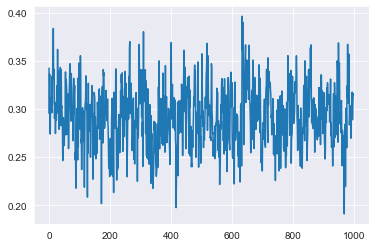

In [68]:
plt.plot(beta[100:, 5])


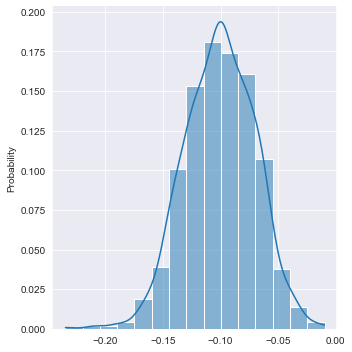

In [69]:
sns.displot(beta[100:,0], stat = "probability", bins = 15, kde = True)

C:\Users\rouau\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:652: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


<AxesSubplot:>

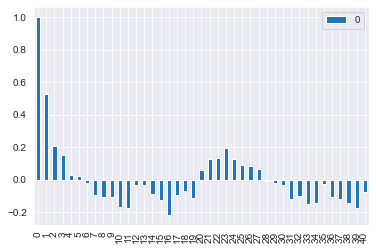

In [70]:
pd.DataFrame(acf(beta[100:200, 0], fft = True)).plot(kind = "bar")

Text(0.5, 0, 'nu')

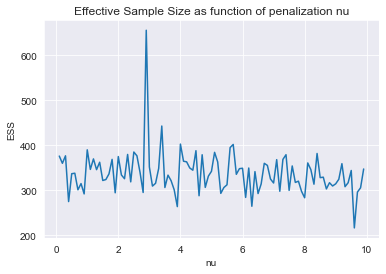

In [71]:
N = 1000
nu = [k/10 for k in range(1, 100)]
alpha = 0.7
tau = [nu[k]**(-1/alpha) for k in range(len(nu))] 
ess = []
for k in range(len(tau)): 
    u = np.empty((N, p))
    W = np.empty((N, p))
    beta = np.empty((N, p))

    beta[0, :] = mu + np.random.randn(p)
    W[0, :] = np.abs(beta[0, :])

    for i in range(1, N):
        u[i, :] = update_u(beta[i-1, :], W[i-1, :], tau[k], alpha, p)
        W[i, :] = update_w(beta[i-1, :], u[i, :], tau[k], alpha, p)
        beta[i, :] = update_beta_bridge(beta[i-1, :], Vinv, u[i, :], W[i, :], tau[k], alpha, p, sig2,  mu)
    
    
    ess.append(essmcmc(beta[100:, ])[0])
plt.plot(nu, ess)
plt.title("Effective Sample Size as function of penalization nu")
plt.ylabel("ESS")
plt.xlabel("nu")

# Comparaison

In [72]:
C = np.linalg.cholesky(X.dot(X.T))
Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
mean = scipy.linalg.solve_triangular(C.T, Cmean, lower = False)
sig2 = 1/n * np.sum((Y-X.T.dot(mean))**2)

In [73]:
nu = 0.5
alpha = 1.5
tau = nu**(-1/alpha)
m = 10000
size = 1000
timp0 = time.time()
beta0 = mv_gaussian(m, p, X, Y, sig2)
w, ess = impsampbridge(m, beta0, X, Y, tau, alpha)
timp = time.time()-timp0
sampl = beta0[np.random.choice(len(beta0), p = w, size = size, replace = True)]

N = m+100
tmcmc0 = time.time()
Vinv = X.dot(X.T)
C = np.linalg.cholesky(Vinv)
Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
mu = scipy.linalg.solve_triangular(C.T, Cmean, lower = False)
u = np.empty((N, p))
W = np.empty((N, p))
beta = np.empty((N, p))

beta[0, :] = mu + np.random.randn(p)
W[0, :] = np.abs(beta[0, :])

for i in range(1, N):
    u[i, :] = update_u(beta[i-1, :], W[i-1, :], tau, alpha, p)
    W[i, :] = update_w(beta[i-1, :], u[i, :], tau, alpha, p)
    beta[i, :] = update_beta_bridge(beta[i-1, :], Vinv, u[i, :], W[i, :], tau, alpha, p, sig2, mu)
tmcmc = time.time()-tmcmc0
sampl2 = beta[-size:, ]

imp = [np.average(beta0[:, i], weights = w) for i in range(p)]
vimp = [N*np.average((beta0[:, i]-imp[i])**2, weights = w**2)/ess for i in range(p)]
g = [sum(acf(beta[50:, i], fft = True)) for i in range(p)]
v = [np.var(beta[50:, i]) for i in range(p)]
vmcmc = [v[i]*(1+2*g[i]) for i in range(p)]
iris = [vmcmc[i]/vimp[i] * timp / tmcmc for i in range(p)]

<ipython-input-74-c27f50cc1e25>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-74-c27f50cc1e25>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
<ipython-input-74-c27f50cc1e25>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


KstestResult(statistic=0.054, pvalue=0.1082872208757189)

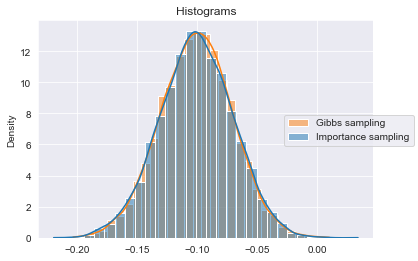

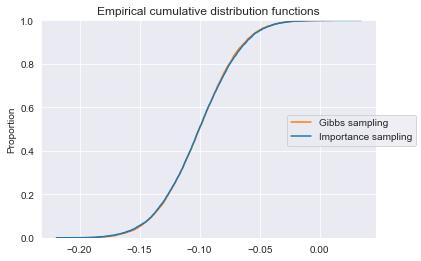

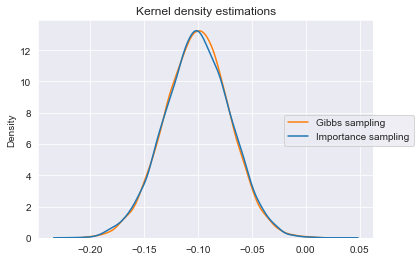

In [74]:
i = 0
fig, ax = plt.subplots()
h1 = sns.histplot(x = beta[100:, i], stat = "density", kde = True, bins = 30, 
                  ax = ax, label = "Gibbs sampling", color = "tab:orange")
h2 = sns.histplot(x = beta0[:, i], stat = "density", kde = True, bins = 30, 
                  ax = ax, label = "Importance sampling", color = "tab:blue", weights = w)
ax.set_title("Histograms")
fig.legend(loc = "right")
fig.show()

fig2, ax2 = plt.subplots()
f1 = sns.ecdfplot(x = beta[500:, i], ax = ax2, label = "Gibbs sampling", color = "tab:orange")
f2 = sns.ecdfplot(x = beta0[:, i], ax = ax2, label = "Importance sampling", color = "tab:blue", weights = w)
ax2.set_title("Empirical cumulative distribution functions")
fig2.legend(loc = "right")
fig2.show()

fig3, ax3= plt.subplots()
kd1 = sns.kdeplot(x = beta[500:, i], ax = ax3, label = "Gibbs sampling", color = "tab:orange")
kd2 = sns.kdeplot(x = beta0[:, i], ax = ax3, label = "Importance sampling", color = "tab:blue", weights = w)
ax3.set_title("Kernel density estimations")
fig3.legend(loc = "right")
fig3.show()

scipy.stats.ks_2samp(sampl[:, i], sampl2[:, i])

In [75]:
timp, tmcmc

(0.3814425468444824, 28.257534503936768)

In [76]:
vimp, vmcmc

([0.0009484118087287186,
  0.0011903404022873612,
  0.002050756385644543,
  0.0005547070876869835,
  0.0022832282988292634,
  0.0010107588245699202,
  0.001599186187232576,
  0.002047067345952458,
  0.0038380323918548766,
  0.004623189473303725,
  0.0009251881448246774,
  0.0007122980292960754,
  0.0015313243985869609],
 [0.004108625728881529,
  0.006417028213366691,
  0.01775704769645485,
  0.001833955295864728,
  0.013666316346694391,
  0.004972294564888953,
  0.009219481281490013,
  0.014161310183866849,
  0.065897222939769,
  0.08625548205172026,
  0.00421179099053713,
  0.0024565270739668943,
  0.008713432830673822])

Text(0.5, 1.0, 'IRIS variance connue')

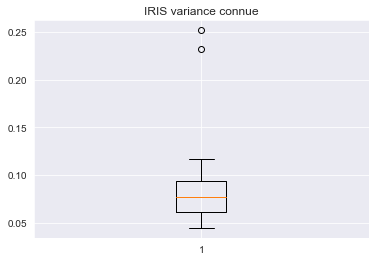

In [77]:
plt.boxplot(iris)
plt.title("IRIS variance connue")

In [78]:
ess

9963.050930613072

In [79]:
essmcmc(beta[100:, :])

[3575.9132056629555,
 2382.968501035744,
 1488.3061707364188,
 7969.007179226292,
 1971.2065643273615,
 2752.139906682008,
 2062.9827203223526,
 1909.925789310693,
 716.3816446701029,
 600.3833653558617,
 3692.279312727446,
 5924.133743201452,
 2545.9552544077033]

# Variance inconnue

# Importance sampling

In [80]:
ksig2 = 1
thetasig2 = 1
alpha = 1.5
tau = nu**(-1/alpha)
m = 10000
C = np.linalg.cholesky(X.dot(X.T))
Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
Yz = Y.T.dot(Y)-Cmean.T.dot(Cmean)
sig2 = invgamma.rvs(a = ksig2+0.5*(n-p), scale = thetasig2+0.5*Yz, size = m)
beta = mv_gaussiansig2(m, p, X, Y, sig2, Cmean, C)
w, ess = impsampbridge(m, beta, X, Y, tau, alpha) 
ess

9961.557396094253

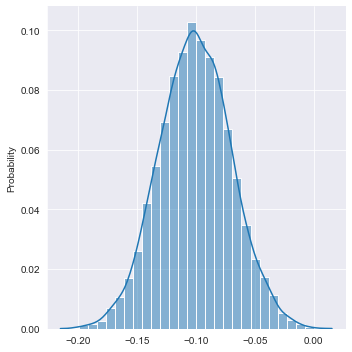

In [81]:
sns.displot(x = beta[:, 0], kind = "hist", stat = "probability", weights = w, kde = True, bins = 30)

Text(0.5, 0, 'nu')

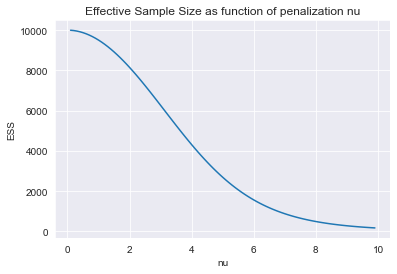

In [82]:
m = 10000
nu = [k/10 for k in range(1, 100)]
alpha = 0.5
ksig2 = 2
thetasig2 = 2
tau = [nu[k]**(-1/alpha) for k in range(len(nu))] 
ess = []
C = np.linalg.cholesky(X.dot(X.T))
Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
Yz = Y.T.dot(Y)-Cmean.T.dot(Cmean)
sig2 = invgamma.rvs(a = ksig2+0.5*(n-p), scale = thetasig2+0.5*Yz, size = m)
beta = mv_gaussiansig2(m, p, X, Y, sig2, Cmean, C)
for k in range(len(tau)): 
    w, essk = impsampbridge(m, beta, X, Y, tau[k], alpha)
    ess.append(essk)
plt.plot(nu, ess)
plt.title("Effective Sample Size as function of penalization nu")
plt.ylabel("ESS")
plt.xlabel("nu")

Text(0.5, 0, 'alpha')

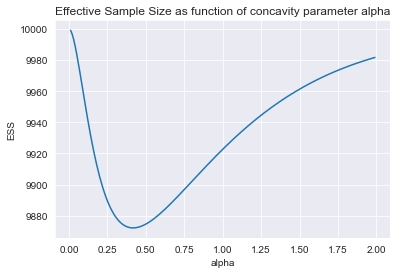

In [83]:
m = 10000
nu = 0.5
ksig2 = 2
thetasig2 = 2
alpha = [k/100 for k in range(1, 200)]
tau = [nu**(-1/alpha[k]) for k in range(len(alpha))] 
ess = []
C = np.linalg.cholesky(X.dot(X.T))
Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
Yz = Y.T.dot(Y)-Cmean.T.dot(Cmean)
sig2 = invgamma.rvs(a = ksig2+0.5*(n-p), scale = thetasig2+0.5*Yz, size = m)
beta = mv_gaussiansig2(m, p, X, Y, sig2, Cmean, C)
for k in range(len(alpha)): 
    w, essk = impsampbridge(m, beta, X, Y, tau[k], alpha[k])
    ess.append(essk)
plt.plot(alpha, ess)
plt.title("Effective Sample Size as function of concavity parameter alpha")
plt.ylabel("ESS")
plt.xlabel("alpha")

# Gibbs sampling

In [84]:
def update_sig2_bridge(beta, X, Y, u, W, ksig2, thetasig2):
    a = ksig2 + 0.5*n
    scale = np.linalg.norm(Y - X.T.dot(np.array(beta)), ord = 2)**2
    return invgamma.rvs(a = a, scale = thetasig2 + scale/2, size = 1)

In [85]:
N = 1000
nu = 0.5
alpha = 0.5
tau = nu**(-1/alpha)

Vinv = X.dot(X.T)
C = np.linalg.cholesky(Vinv)
Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
mu = scipy.linalg.solve_triangular(C.T, Cmean, lower = False)

u = np.empty((N, p))
W = np.empty((N, p))
beta = np.empty((N, p))
sig2 = np.empty(N)


beta[0, :] = mu + np.random.randn(p)
W[0, :] = np.abs(beta[0, :])
sig2[0] = invgamma.rvs(a = ksig2, scale = thetasig2, size = 1)

for i in range(1, N):
    u[i, :] = update_u(beta[i-1, :], W[i-1, :], tau, alpha, p)
    W[i, :] = update_w(beta[i-1, :], u[i, :], tau, alpha, p)
    beta[i, :] = update_beta_bridge(beta[i-1, :], Vinv, u[i, :], W[i, :], tau, alpha, p, sig2[i-1], mu)
    sig2[i] = update_sig2_bridge(beta[i, :], X, Y, u[i, :], W[i, :], ksig2, thetasig2)
    

essmcmc(beta[100:, ])

[304.1462185838974,
 186.32074551069098,
 131.45424343149963,
 665.4836258149928,
 167.48896756692736,
 197.13181696381216,
 166.0373216328231,
 123.29641153760205,
 57.16253681624481,
 43.71876416702943,
 220.74551129722911,
 488.2976545103739,
 202.31850038687327]

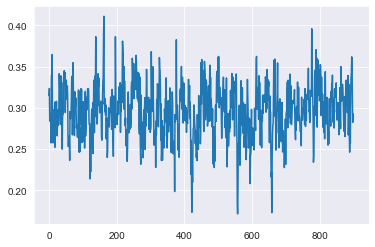

In [86]:
plt.plot(beta[100:, 5])

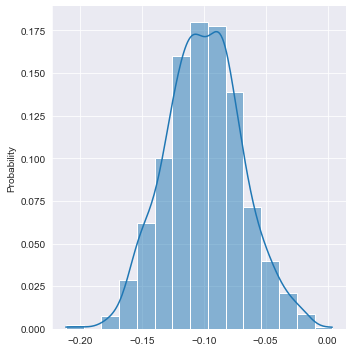

In [87]:
sns.displot(beta[100:,0], stat = "probability", bins = 15, kde = True)

Text(0.5, 0, 'nu')

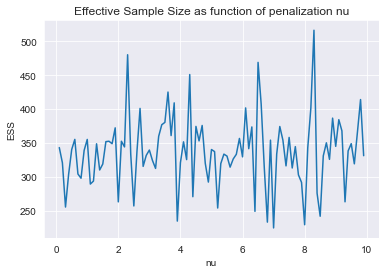

In [88]:
N = 1000
nu = [k/10 for k in range(1, 100)]
alpha = 1.5
tau = [nu[k]**(-1/alpha) for k in range(len(nu))] 
ess = []
Vinv = X.dot(X.T)
C = np.linalg.cholesky(Vinv)
Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
mu = scipy.linalg.solve_triangular(C.T, Cmean, lower = False)
for k in range(len(tau)): 
    u = np.empty((N, p))
    W = np.empty((N, p))
    beta = np.empty((N, p))
    sig2 = np.empty(N)

    beta[0, :] = mu + np.random.randn(p)
    W[0, :] = np.abs(beta[0, :])
    sig2[0] = invgamma.rvs(a = ksig2, scale = thetasig2, size = 1)

    for i in range(1, N):
        u[i, :] = update_u(beta[i-1, :], W[i-1, :], tau[k], alpha, p)
        W[i, :] = update_w(beta[i-1, :], u[i, :], tau[k], alpha, p)
        beta[i, :] = update_beta_bridge(beta[i-1, :], Vinv, u[i, :], W[i, :], tau[k], alpha, p, sig2[i-1],  mu)
        sig2[i] = update_sig2_bridge(beta[i, :], X, Y, u[i, :], W[i, :], ksig2, thetasig2)
    
    
    ess.append(essmcmc(beta[100:, ])[0])
plt.plot(nu, ess)
plt.title("Effective Sample Size as function of penalization nu")
plt.ylabel("ESS")
plt.xlabel("nu")

In [116]:
nu = 2
alpha = 1.5
ksig2 = 1
thetasig2 = 1
tau = nu**(-1/alpha)
m = 10000
size = 1000
timp0 = time.time()
Vinv = X.dot(X.T)
C = np.linalg.cholesky(Vinv)
Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
Yz = Y.T.dot(Y)-Cmean.T.dot(Cmean)
sig2 = invgamma.rvs(a = ksig2+0.5*(n-p), scale = thetasig2+0.5*Yz, size = m)
beta0 = mv_gaussiansig2(m, p, X, Y, sig2, Cmean, C)
w, ess = impsampbridge(m, beta0, X, Y, tau, alpha)
timp = time.time()-timp0
sampl = beta0[np.random.choice(len(beta0), p = w, size = size, replace = True)]

N = m+100
tmcmc0 = time.time()
C = np.linalg.cholesky(X.dot(X.T))
Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
mu = scipy.linalg.solve_triangular(C.T, Cmean, lower = False)
u = np.empty((N, p))
W = np.empty((N, p))
beta = np.empty((N, p))
sig2 = np.empty(N)


beta[0, :] = mu + np.random.randn(p)
W[0, :] = np.abs(beta[0, :])
sig2[0] = invgamma.rvs(a = ksig2, scale = thetasig2, size = 1)

for i in range(1, N):
    u[i, :] = update_u(beta[i-1, :], W[i-1, :], tau, alpha, p)
    W[i, :] = update_w(beta[i-1, :], u[i, :], tau, alpha, p)
    beta[i, :] = update_beta_bridge(beta[i-1, :], Vinv, u[i, :], W[i, :], tau, alpha, p, sig2[i-1], mu)
    sig2[i] = update_sig2_bridge(beta[i, :], X, Y, u[i, :], W[i, :], ksig2, thetasig2)
    
tmcmc = time.time()-tmcmc0
sampl2 = beta[-size:, ]

imp = [np.average(beta0[:, i], weights = w) for i in range(p)]
vimp = [N*np.average((beta0[:, i]-imp[i])**2, weights = w**2)/ess for i in range(p)]
g = [sum(acf(beta[50:, i], fft = True)) for i in range(p)]
v = [np.var(beta[50:, i]) for i in range(p)]
vmcmc = [v[i]*(1+2*g[i]) for i in range(p)]
iris = [vmcmc[i]/vimp[i] * timp / tmcmc for i in range(p)]

C:\Users\rouau\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:652: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


<ipython-input-117-1fc4f31a1739>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-117-1fc4f31a1739>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
<ipython-input-117-1fc4f31a1739>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


KstestResult(statistic=0.038, pvalue=0.4659595288557257)

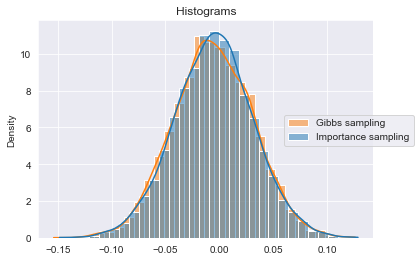

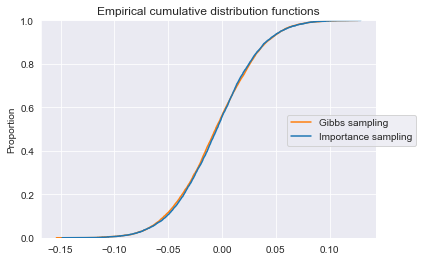

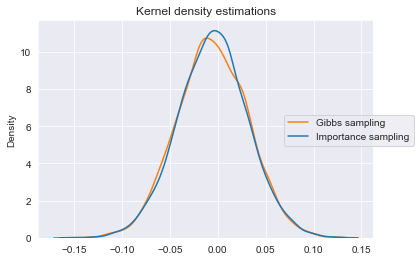

In [117]:
i = 0
fig, ax = plt.subplots()
h1 = sns.histplot(x = beta[500:, i], stat = "density", kde = True, bins = 30, 
                  ax = ax, label = "Gibbs sampling", color = "tab:orange")
h2 = sns.histplot(x = beta0[:, i], stat = "density", kde = True, bins = 30, 
                  ax = ax, label = "Importance sampling", color = "tab:blue", weights = w)
ax.set_title("Histograms")
fig.legend(loc = "right")
fig.show()

fig2, ax2 = plt.subplots()
f1 = sns.ecdfplot(x = beta[500:, i], ax = ax2, label = "Gibbs sampling", color = "tab:orange")
f2 = sns.ecdfplot(x = beta0[:, i], ax = ax2, label = "Importance sampling", color = "tab:blue", weights = w)
ax2.set_title("Empirical cumulative distribution functions")
fig2.legend(loc = "right")
fig2.show()

fig3, ax3= plt.subplots()
kd1 = sns.kdeplot(x = beta[500:, i], ax = ax3, label = "Gibbs sampling", color = "tab:orange")
kd2 = sns.kdeplot(x = beta0[:, i], ax = ax3, label = "Importance sampling", color = "tab:blue", weights = w)
ax3.set_title("Kernel density estimations")
fig3.legend(loc = "right")
fig3.show()

scipy.stats.ks_2samp(sampl[:, i], sampl2[:, i])

In [91]:
timp, tmcmc

(0.3861987590789795, 29.90720224380493)

In [92]:
vimp, vmcmc

([0.0010024141155025876,
  0.001304056119469113,
  0.002185790745757977,
  0.0006121456169162758,
  0.0025031948314213756,
  0.0011022978821144539,
  0.0016855288649992373,
  0.0022371696294734966,
  0.004261147552885761,
  0.004978634653359919,
  0.001016954684392603,
  0.0007710033470641426,
  0.0016503513830424539],
 [0.003852030717573419,
  0.006499806719275944,
  0.018352469499666013,
  0.0017586907837184855,
  0.016179579159588717,
  0.005540796080702399,
  0.009967909095458843,
  0.013308460664208516,
  0.06007167236407557,
  0.0784069994367572,
  0.004609283681917118,
  0.002495911963039597,
  0.010133426579373701])

In [93]:
ess

9442.600424082993

In [94]:
essmcmc(beta[100:, ])

[3453.584549127024,
 2411.5829010359676,
 1497.3955645632946,
 8223.831908935856,
 1764.5044935922876,
 2979.5505148608045,
 2381.454131287168,
 2047.4928275773,
 707.9493815210151,
 692.1462798701042,
 3629.409580294782,
 6316.551838020165,
 2398.6078753355173]

# Comparaison avec le Bayesian Lasso

In [118]:
nu = 0.5
alpha = 1
ksig2 = 1
thetasig2 = 1
tau = nu**(-1/alpha)
m = 10000
N = m + 100
size = 1000
tmcmc0s = time.time()
sig2 = np.empty(N)
tau2inv = np.empty((N, p))
beta0 = np.empty((N, p))
sig2[0] = invgamma.rvs(a = ksig2, scale = thetasig2)
tau2 = expon.rvs(scale = 2/nu**2, size = p)
tau2inv[0, :] = 1/tau2

for i in range(1, N):
    beta0[i, :] = update_beta(X, Y, p, tau2inv[i-1, :], sig2[i-1])
    tau2inv[i, :] = update_tau2inv(X, Y, p, beta0[i, :], sig2[i-1], nu)
    sig2[i] = update_sig2(X, Y, p, beta0[i, :], tau2inv[i, :], ksig2, thetasig2)
tmcmc0 = time.time()-tmcmc0s
sampl = beta0[-size:, ]


tmcmc1 = time.time()
Vinv = X.dot(X.T)
C = np.linalg.cholesky(Vinv)
Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
mu = scipy.linalg.solve_triangular(C.T, Cmean, lower = False)
u = np.empty((N, p))
W = np.empty((N, p))
beta = np.empty((N, p))
sig2 = np.empty(N)


beta[0, :] = mu + np.random.randn(p)
W[0, :] = np.abs(beta[0, :])
sig2[0] = invgamma.rvs(a = ksig2, scale = thetasig2, size = 1)

for i in range(1, N):
    u[i, :] = update_u(beta[i-1, :], W[i-1, :], tau, alpha, p)
    W[i, :] = update_w(beta[i-1, :], u[i, :], tau, alpha, p)
    beta[i, :] = update_beta_bridge(beta[i-1, :], Vinv, u[i, :], W[i, :], tau, alpha, p, sig2[i-1], mu)
    sig2[i] = update_sig2_bridge(beta[i, :], X, Y, u[i, :], W[i, :], ksig2, thetasig2)
    
tmcmc = time.time()-tmcmc1
sampl2 = beta[-size:, ]

g0 = [sum(acf(beta0[50:, i], fft = True)) for i in range(p)]
v0 = [np.var(beta0[50:, i]) for i in range(p)]
vmcmc0 = [v0[i]*(1+2*g0[i]) for i in range(p)]
g = [sum(acf(beta[50:, i], fft = True)) for i in range(p)]
v = [np.var(beta[50:, i]) for i in range(p)]
vmcmc = [v[i]*(1+2*g[i]) for i in range(p)]

C:\Users\rouau\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:652: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


<ipython-input-119-6111a03c2202>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-119-6111a03c2202>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
<ipython-input-119-6111a03c2202>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


KstestResult(statistic=0.033, pvalue=0.647814872077161)

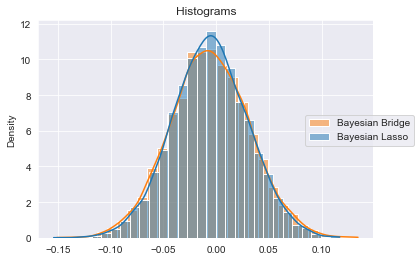

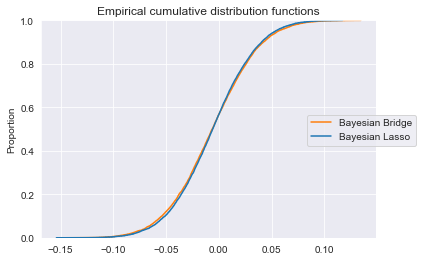

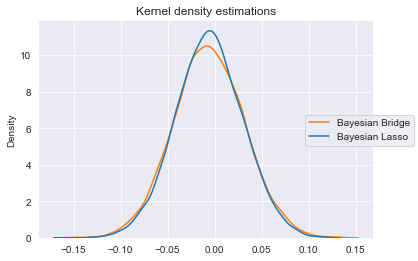

In [119]:
i = 0
fig, ax = plt.subplots()
h1 = sns.histplot(x = beta[500:, i], stat = "density", kde = True, bins = 30, 
                  ax = ax, label = "Bayesian Bridge", color = "tab:orange")
h2 = sns.histplot(x = beta0[500:, i], stat = "density", kde = True, bins = 30, 
                  ax = ax, label = "Bayesian Lasso", color = "tab:blue")
ax.set_title("Histograms")
fig.legend(loc = "right")
fig.show()

fig2, ax2 = plt.subplots()
f1 = sns.ecdfplot(x = beta[500:, i], ax = ax2, label = "Bayesian Bridge", color = "tab:orange")
f2 = sns.ecdfplot(x = beta0[500:, i], ax = ax2, label = "Bayesian Lasso", color = "tab:blue")
ax2.set_title("Empirical cumulative distribution functions")
fig2.legend(loc = "right")
fig2.show()

fig3, ax3= plt.subplots()
kd1 = sns.kdeplot(x = beta[500:, i], ax = ax3, label = "Bayesian Bridge", color = "tab:orange")
kd2 = sns.kdeplot(x = beta0[500:, i], ax = ax3, label = "Bayesian Lasso", color = "tab:blue")
ax3.set_title("Kernel density estimations")
fig3.legend(loc = "right")
fig3.show()

scipy.stats.ks_2samp(sampl[:, i], sampl2[:, i])

In [97]:
tmcmc0, tmcmc

(12.702882051467896, 31.067142963409424)

In [98]:
vmcmc0, vmcmc

([0.002900035853575876,
  0.003515114566519263,
  0.005173665112510617,
  0.001799525610117224,
  0.007350779872893166,
  0.0031836330198899733,
  0.004290444194753018,
  0.0060815432813668205,
  0.012444904846245526,
  0.01475612684187336,
  0.0028593053376742344,
  0.0022988461723234713,
  0.004642111847663874],
 [0.004482966914604218,
  0.00644910271037522,
  0.016223174995462074,
  0.0020445061313030303,
  0.017364931030895342,
  0.006304835463728955,
  0.011375375917909063,
  0.014107525242494015,
  0.06328417757920657,
  0.07764883701687504,
  0.0047587945479351185,
  0.0027274438947985963,
  0.011015235630538179])

# Données corrélées

In [99]:
alphad = [k/100 for k in range(1, 51)]+[k/200 for k in range(100, 199)]
alpha0 = np.array([1, 0.5, 0.2, 0.17, .001])
k0 = len(alpha0)
ksig2 = 1
thetasig2 = 1
p = 15
n = 100
lamb = 1
alpha = 1
tau = lamb**(-1/alpha)
m = 1000
N = m+100
ess = []
essgibbs = []
essbridge = []
delta = np.array([0 if k%3 == 0 else np.random.randn() for k in range(p)])
for k in range(len(alphad)):

    X, Y = gencorr(n, p, alphad[k], k0, delta, alpha0)
    #IS
    Vinv = X.dot(X.T)
    C = np.linalg.cholesky(Vinv)
    Cmean = scipy.linalg.solve_triangular(C, X.dot(Y), lower = True)
    Yz = Y.T.dot(Y)-Cmean.T.dot(Cmean)
    sig2 = invgamma.rvs(a = ksig2+0.5*n, scale = thetasig2+0.5*Yz, size = m)
    beta0 = mv_gaussiansig2(m, p, X, Y, sig2, Cmean, C)
    w, essk = impsampsig2(m, beta0, sig2, X, Y, lamb) 
    ess.append(essk)
    #Gibbs
    sig2 = np.empty(N)
    tau2inv = np.empty((N, p))
    beta1 = np.empty((N, p))
    sig2[0] = invgamma.rvs(a = ksig2, scale = thetasig2)
    tau2 = expon.rvs(scale = 2/lamb**2, size = p)
    tau2inv[0, :] = 1/tau2

    for i in range(1, N):
        beta1[i, :] = update_beta(X, Y, p, tau2inv[i-1, :], sig2[i-1])
        tau2inv[i, :] = update_tau2inv(X, Y, p, beta1[i, :], sig2[i-1], lamb)
        sig2[i] = update_sig2(X, Y, p, beta1[i, :], tau2inv[i, :], ksig2, thetasig2)
    essgibbs.append(essmcmc(beta1[100:, ])[0])
    
    #Bayesian Bridge alpha = 1
    mu = scipy.linalg.solve_triangular(C.T, Cmean, lower = False)
    u = np.empty((N, p))
    W = np.empty((N, p))
    beta = np.empty((N, p))
    sig2 = np.empty(N)
    beta[0, :] = mu + np.random.randn(p)
    W[0, :] = np.abs(beta[0, :])
    sig2[0] = invgamma.rvs(a = ksig2, scale = thetasig2, size = 1)
    for i in range(1, N):
        u[i, :] = update_u(beta[i-1, :], W[i-1, :], tau, alpha, p)
        W[i, :] = update_w(beta[i-1, :], u[i, :], tau, alpha, p)
        beta[i, :] = update_beta_bridge(beta[i-1, :], Vinv, u[i, :], W[i, :], tau, alpha, p, sig2[i-1], mu)
        sig2[i] = update_sig2_bridge(beta[i, :], X, Y, u[i, :], W[i, :], ksig2, thetasig2)
    essbridge.append(essmcmc(beta[100:, ])[0])

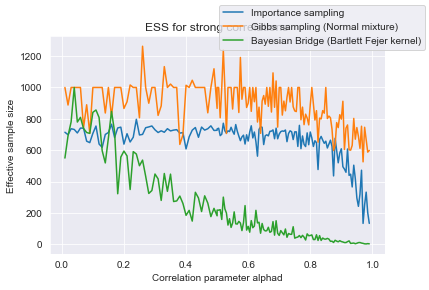

In [100]:
fig, ax = plt.subplots()
plt.plot(alphad, ess, color = "tab:blue", label = "Importance sampling")
plt.plot(alphad, essgibbs, color = "tab:orange", label = "Gibbs sampling (Normal mixture)")
plt.plot(alphad, essbridge, color = "tab:green", label = "Bayesian Bridge (Bartlett Fejer kernel)")
plt.ylabel("Effective sample size")
plt.xlabel("Correlation parameter alphad")
ax.set_title("ESS for strong correlations")
fig.legend(loc = "upper right")
plt.show()

# Mélange normal

In [111]:
X, Y = load_diabetes(return_X_y=True)
n, p = X.shape
X= normalize(X)
Y = (Y-np.mean(Y))/np.std(Y)